# Учебный проект 15_Прогнозирование заказов такси

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
* [Построение моделей прогнозирования количества заказов такси](#Моделирование)
    * [Подготовка данных для построения моделей](#Моделирование_подготовка)
    * [Блок прогнозирования заказов такси](#Моделирование_блок)
        * [Использование константного значения](#Моделирование_блок_константа)
        * [Линейная регрессия](#Моделирование_блок_lr)
        * [SARIMA](#Моделирование_блок_sarima)
        * [Holt-Winters](#Моделирование_блок_hw)
        * [RandomForestRegressor](#Моделирование_блок_rfr)
        * [GradientBoostingRegressor](#Моделирование_блок_gbr)
* [Вывод](#Вывод)

## Описание проекта <a class = 'anchor' id = 'Описание'></a>

На исследовании находятся **исторические** данные с `информацией о заказах такси в аэропортах`, которые были предоставлены руководством компании "Чётенькое такси".

---

`Задача`

Разработать модель машинного обучения для **прогнозирования количества заказов такси** на следующий час.

---

`Путь решения`

1. Собрать исторические данные о заказах такси в аэропорту. Провести ресемплирование значений по одному часу;
2. Провести предобработку значений в наборах данных; Провести исследовательский анализ данных для выявления закономерностей, применимых к последующей настройке моделей МО;
3. Построить модель прогнозирования количества такси с перебором различных значений гиперпараметров;
4. Оценить качество моделей на метриках;
5. Сформировать вывод о подготовленных решениях.

---

`Располагаемые данные`

**Исторические данные о количестве заказов такси - taxi**
* datetime - показатель даты и времени совершенных заказов;
* num_orders - количество заказов.

## Импорт библиотек Python <a class = 'anchor' id = 'Импорторт'></a>

1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для исследования временных рядов;
    * для решения задач машинного обучения:
        * модель линейной регрессии;
        * метрики оценки эффективности моделей;
        * механизмы отбора данных данных.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [27]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np
import math

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# установка размеров для последующих графиков в проекте
plt.rcParams['figure.figsize'] = (10, 5)

# модели регрессии
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# метрики оценки эффективности моделей
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            root_mean_squared_error,
                            mean_absolute_percentage_error)

# вспомогательные механизмы для задач машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import shuffle

# импорт методов для исследования временных рядов
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# импорт моделей прогнозирования временных рядов
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [49]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной RANDOM_STATE для фиксирования случайности
# инициализация переменной TEST_SIZE для фиксирования размера тестовой выборки при разбиении наборов данных
RANDOM_STATE = 42
TEST_SIZE = 0.1

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn.
    * для решения задач машинного обучения:
        * LinearRegression - модель логистической регрессии;
        * RandomForestRegressor - модель случайного леса;
        * GradientBoostingRegressor - модель градиентного бустинга;
        * SARIMAX - модель SARIMAX для прогнозирования временных рядов;
        * ExponentialSmoothing - модель экспоненциального сглаживания;
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * GridSearchCV - механизм поиска гиперпараметров с перебором по "сетке";
        * cross_val_score - механизм кросс-валидации;
        * shuffle - механизм перемешивания данных.
    * для исследования временных рядов:
        * plot_acf - функция для построения графика автокорреляции;
        * plot_pacf - функция для построения графика частичной автокорреляции;
        * seasonal_decompose - функция для декомпозиции временного ряда на компоненты;
        * adfuller - функция для теста стационарности временного ряда.
    * для отключения предупреждений.
2. Инициализированы переменные:
    * **TEST_SIZE** для фиксирования размера тестовой выборки при разбиении наборов данных;
    * **RANDOM_STATE** для фиксирования случайности.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook - инициализация переменной **taxi**;
2. Вывод на экран параметров датасетов:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * визуализация распределений количественных показателей.
3. Формирование вывода по итогам данного этапа.

In [3]:
# загрузка данных в рабочую среду

try:
    taxi = pd.read_csv('~/Desktop/YandexPraktikum_projects/datasets/taxi.csv')
except:
    taxi = pd.read_csv('/datasets/taxi.csv')

In [4]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

In [5]:
# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака {column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений {column}', fontsize = 10)
    sns.histplot(data = df, x = df[column], bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака {column}')
    plt.title(f'Диаграмма размаха значений {column}', fontsize = 10)
    sns.boxplot(data = df, x = df[column])
    plt.grid(False)
    plt.show()

Структура набора данных taxi


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None



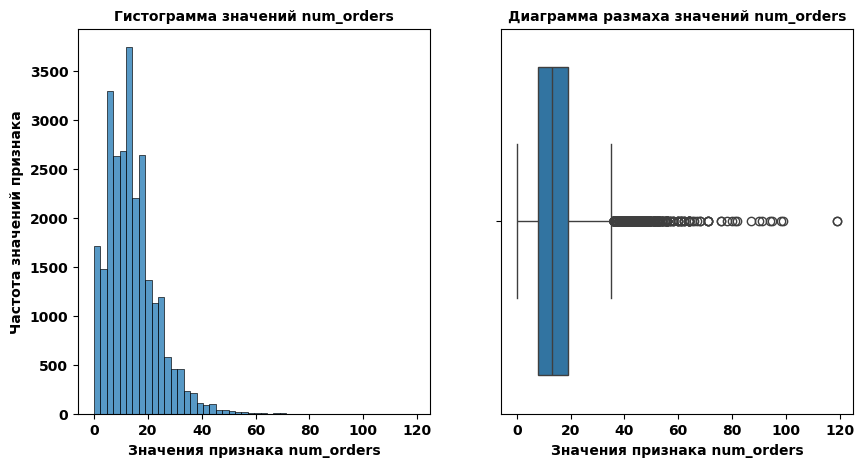

In [6]:
# вывод на экран параметров датасета 'taxi'
first_meeting(taxi, 'taxi')

# вывод на экран графика распределения непрерывной количественной величины 'num_orders'
num_distribution(taxi, 'num_orders', 50)

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **taxi**;
2. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения**;
    * Тип значений по признаку **datetime** не соответствует семантике столбца - необходимо выполнить конвертацию значений;
    * Наблюдаются аномально большие значения по признаку **num_orders** - необходимо провести анализ и выявить причину возникновения таких значений.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Конвертация значений признака **datetime** к типу данных DateTime;
2. Установка индексам значений столбца **datetime**;
3. Сортировка значений по возрастанию;
4. Ресемплирование значений по одному часу.
5. Формирование вывода по итогам данного этапа.

In [7]:
# конвертация значений признака 'datetime' к типу данных DateTime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

# установка индексам значений столбца 'datetime'
taxi = taxi.set_index('datetime')

# сортировка значений по возрастанию
taxi.sort_index(inplace = True)

# ресемплирование значений по одному часу
taxi = taxi.resample('1H').sum()

# проверка монотонности индекса
print('Является ли индекс монотонным?', taxi.index.is_monotonic_increasing)

# вывод на экран первых 5 строк обновленного набора данных
taxi.head()

Является ли индекс монотонным? True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

1. Проведена конвертация значений признака **datetime** к типу данных DateTime;
2. Выполнена установка индексам значений столбца **datetime**;
3. Выполнена сортировка значений по возрастанию с заменой предыдущего набора;
4. Выполнено ресемплирование значений по одному часу.

Набор данных готов к этапу **Исследовательского анализа**.

## Исследовательский анализ данных <a class = 'anchor' id = 'Исследование'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Исследование временных границ данных - вывод на экран минимального и максимального значения дат;
2. Построение графика временного ряда;
3. Проведение декомпозиции временного ряда на компоненты;
4. Проведение теста стационарности временного ряда;
5. Построение графиков автокорреляции и частичной автокорреляции;
6. Формирование вывода по итогам данного этапа.

In [8]:
# вывод на экран минимального и максимального значений даты и времени
print(f'Минимальное значение даты и времени: {taxi.index.min()}')
print(f'Максимальное значение даты и времени: {taxi.index.max()}')

Минимальное значение даты и времени: 2018-03-01 00:00:00
Максимальное значение даты и времени: 2018-08-31 23:00:00


**Вывод по промежуточному этапу**

В наборе данных приведены данные за один календарный год - **2018** - в период с марта по август.

Таким образом, к набору данных можно задать следующие исследовательские вопросы:
* Как меняется количество заказов такси в зависимости от часа / дня недели / месяца?
* Какие дни являются наиболее загруженными / свободными?

Для ответа на поставленные вопросы необходимо добавить в набор данных дополнительные признаки - месяц, число месяца, день недели, час дня.

In [9]:
# ввод новых признаков в набор данных - месяц, число месяца, день недели, час дня.
def data_features(df : pd.DataFrame) -> pd.DataFrame:
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df

# применение функции к набору данных
taxi = data_features(taxi)

# вывод на экран первых 5 строк обновленного набора данных
taxi.head()

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


In [10]:
# инициализация пользовательской функции по построению гистограмм по передаваемым метрикам
def histogram_plotting(data: pd.DataFrame, feature : str, bins: int, x_size: int, y_size: int, feature_xlabel : str):
    # вычисление статистических метрик для дальнейшей визуализации
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    upper_bound = q3 + 1.5 * (q3 - q1)
    lower_bound = q1 - 1.5 * (q3 - q1)

    # построение визуализации
    plt.figure(figsize = (x_size, y_size))
    plt.hist(data[feature], color = 'blue', edgecolor = 'white', bins = bins)
    plt.axvline(upper_bound, c = 'red', ls = '-', label = 'верхняя граница допустимых значений')
    plt.axvline(q3, c = 'red', ls = '--', label = '3 квартиль значений')
    plt.axvline(q1, c = 'black', ls = '--', label = '1 квартиль значений')
    plt.axvline(lower_bound, c = 'black', ls = '-', label = 'нижняя граница допустимых значений')
    plt.title(f'Гистограмма распределения значений по метрике: {feature_xlabel}', fontsize = 10)
    plt.xlabel(feature_xlabel)
    plt.ylabel('Количество значений по метрике')
    plt.legend(bbox_to_anchor = (1, 0.6))
    plt.show()

    # вывод статистических метрик на экран
    print('Верхняя допустимая граница значений:', upper_bound)
    print('Нижняя допустимая граница значений:', lower_bound)
    print('Медианное значение:', data[feature].median())
    print('Среднее значение:', round(data[feature].mean(), 2))

    # расчет доли аномальных значений по метрике
    print('Доля значений, выходящих за верхнюю границу: {:.2%}'.format(data[data[feature] > upper_bound].shape[0] / data[feature].shape[0]))
    print('Доля значений, выходящих за нижнюю границу: {:.2%}'.format(data[data[feature] < lower_bound].shape[0] / data[feature].shape[0]))

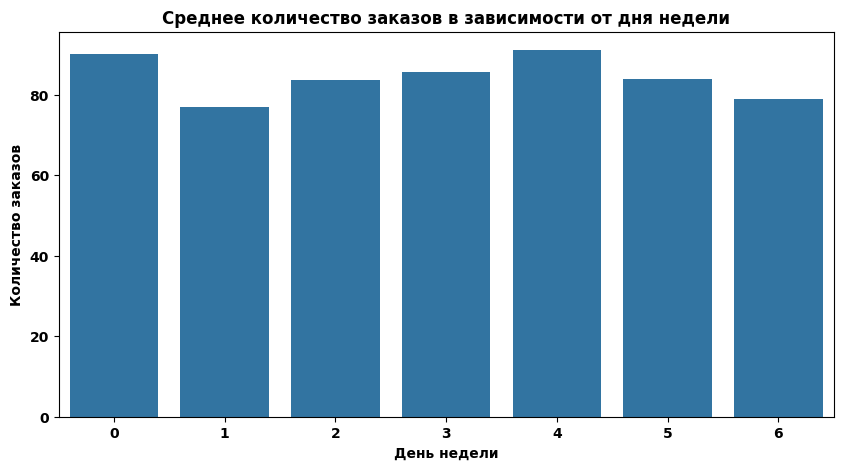

In [11]:
# построение графика количества заказов в зависимости от дня недели
sns.barplot(taxi, x = 'dayofweek', y = 'num_orders', errorbar = None, estimator = 'mean')
plt.title('Среднее количество заказов в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

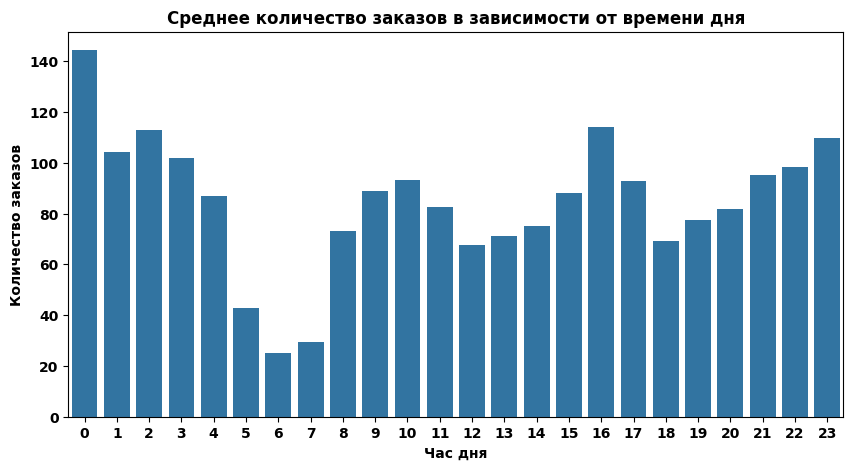

In [12]:
# построение графика количества заказов в зависимости от времени дня
sns.barplot(taxi, x = 'hour', y = 'num_orders', errorbar = None, estimator = 'mean')
plt.title('Среднее количество заказов в зависимости от времени дня')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.show()

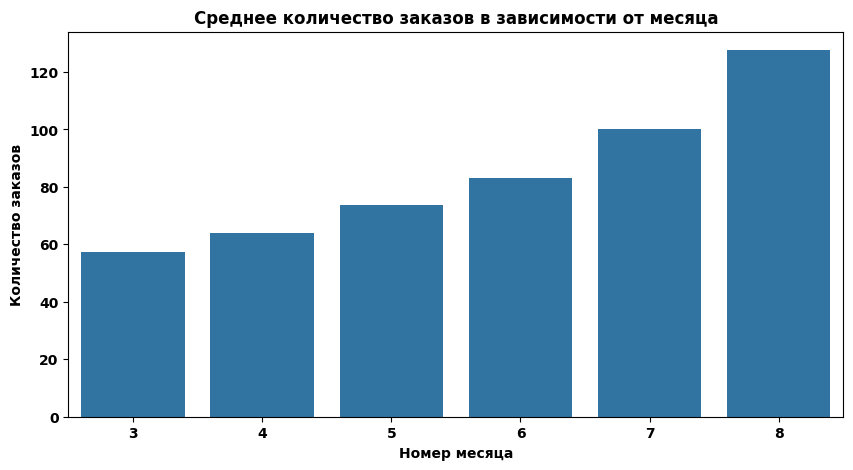

In [13]:
# построение графика количества заказов в зависимости от месяца
sns.barplot(taxi, x = 'month', y = 'num_orders', errorbar = None, estimator = 'mean')
plt.title('Среднее количество заказов в зависимости от месяца')
plt.xlabel('Номер месяца')
plt.ylabel('Количество заказов')
plt.show()

**Вывод по промежуточному этапу**

При анализе графиков среднего количества заказов такси в различных временных разрезах (время суток, день недели, номер месяца) можно сделать следующие выводы:

1. По дням недели - наибольшее количество заказов приходится на **пятницу** и **понедельник**;
2. По времени суток - наблюдаются всплески заказов в следующие периоды:
    * Ночной период - **21 - 24 часа**;
    * Утренний период - **8 - 11 часов**;
    * Вечерний период - **15 - 17 часов**.
3. По номеру месяца - наибольшее количество заказов приходится на **август** месяц.

Для более глубокого анализа необходимо провести декомпозицию временного ряда на компоненты - тренд, сезонность и остаток.

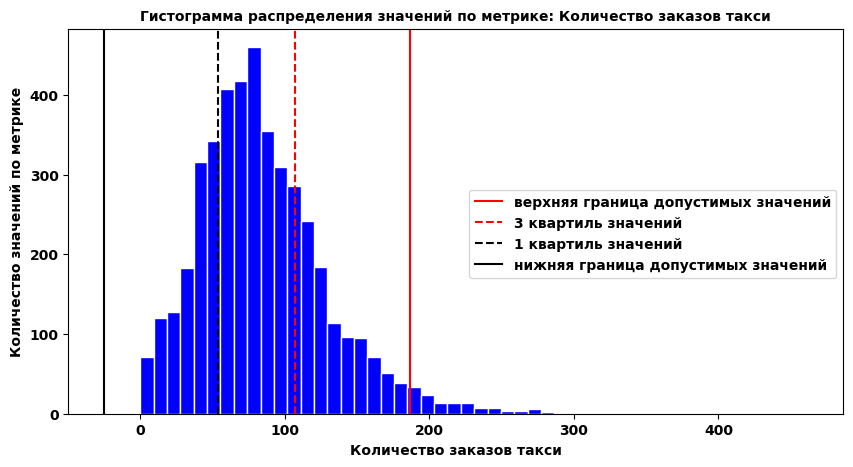

Верхняя допустимая граница значений: 186.5
Нижняя допустимая граница значений: -25.5
Медианное значение: 78.0
Среднее значение: 84.42
Доля значений, выходящих за верхнюю границу: 2.74%
Доля значений, выходящих за нижнюю границу: 0.00%


In [14]:
# анализ графиков распределения значений по метрике 'num_orders'
histogram_plotting(taxi, 'num_orders', 50, 10, 5, 'Количество заказов такси')

In [15]:
# вывод на экран показателей даты для аномально больших значений
print('Уникальные значения дней недели для аномально больших значений:', sorted(taxi[taxi['num_orders'] > 186]['dayofweek'].unique()))
print('Уникальные значения часов для аномально больших значений:', sorted(taxi[taxi['num_orders'] > 186]['hour'].unique()))

Уникальные значения дней недели для аномально больших значений: [0, 1, 2, 3, 4, 5, 6]
Уникальные значения часов для аномально больших значений: [0, 1, 2, 3, 4, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 23]


**Вывод по промежуточному этапу**

По итогам гистограммы распределения значений можно сделать следующие выводы:
* Аномально большие значения наблюдаются в каждый день недели - нет зависимости от дня недели;
* Можно отметить суточную составляющую аномально больших значений - они наблюдаются в вечернее и ночное время.

Скорее всего в этот период наблюдается **высокая загруженность аэропорта** - возможно, что это связано с конечной ценой авиабилетов. Вылет и прилет в вечернее/ночное время стоит дешевеле, чем прилет в дневное или в утреннее.

In [16]:
# построение интерактивного графика значений временного ряда

# инициализация пользовательской функции аггрегации значений в зависимости от временного шага
def resample_data(df, freq):
    if freq == 'Y':
        return df.resample('Y').mean().round(2)
    elif freq == 'M':
        return df.resample('M').mean().round(2)
    elif freq == 'D':
        return df.resample('D').mean().round(2)
    elif freq == 'H':
        return df  # исходные часовые данные
    else:
        raise ValueError("freq должен быть 'Y', 'M', 'D' или 'H'")

# создание фигуры с выпадающим меню
fig = go.Figure()

# Добавляем следы для каждого уровня масштабирования
for freq, name in [('Y', 'Год'), ('M', 'Месяц'), ('D', 'День'), ('H', 'Час')]:
    df_resampled = resample_data(taxi, freq)
    fig.add_trace(
        go.Scatter(
            x=df_resampled.index,
            y=df_resampled['num_orders'],
            mode='lines+markers',
            name=name,
            visible=(freq == 'H'),  # изначально видим только часовые данные
            hovertemplate='%{x|%Y-%m-%d}<br>Значение: %{y:.2f}<extra></extra>'
        )
    )

# настройка выпадающего меню для выбора масштаба
fig.update_layout(
    title='Интерактивный график временного ряда<br><sup>Меняйте масштаб через выпадающее меню</sup>',
    xaxis_title='Время',
    yaxis_title='Значение',
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label='Час',
                    method='update',
                    args=[{'visible': [False, False, False, True]},
                          {'title': 'Количество заказов такси: почасовые данные'}]
                ),
                dict(
                    label='День',
                    method='update',
                    args=[{'visible': [False, False, True, False]},
                          {'title': 'Количество заказов такси: дневные средние'}]
                ),
                dict(
                    label='Месяц',
                    method='update',
                    args=[{'visible': [False, True, False, False]},
                          {'title': 'Количество заказов такси: месячные средние'}]
                ),
                dict(
                    label='Год',
                    method='update',
                    args=[{'visible': [True, False, False, False]},
                          {'title': 'Количество заказов такси: годовые средние'}]
                )
            ],
            direction='down',
            showactive=True,
            x=0.7,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ],
    hovermode='x unified',
    height=600
)

# вывод график
fig.show()

**Вывод по промежуточному этапу**

По построенному графику заметен возрастающий линейный тренд на количество заказов такси - **среднее количество заказов растет на протяжении исследуемого периода данных**

Вероятно это связано с обилием перелетов в летний отпускной период.

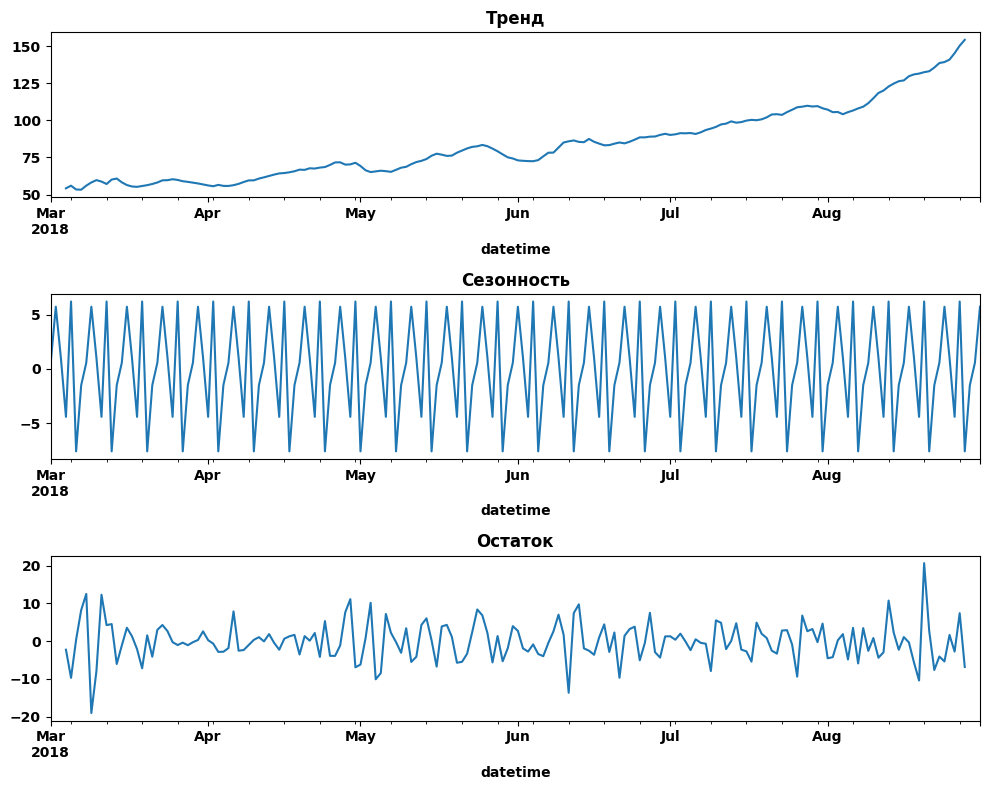

In [17]:
# построение графика декомпозиции временного ряда
decomposed = seasonal_decompose(taxi[['num_orders']].resample('1D').mean())

plt.figure(figsize = (10, 8))
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Остаток')
plt.tight_layout()
plt.show()

**Вывод по промежуточному этапу**

По совокупным графикам декомпозиции и группировки значений временного ряда можно сделать следующие выводы:
* Наблюдается **линейный тренд** на увеличение количества заказов такси;
* Наблюдается **ежедневная сезонность** - количество заказов такси увеличивается в вечернее время (в период 21 - 24 часов) и уменьшается в утреннее время (в период 5 - 7 часов);
* Наблюдается **еженедельная сезонность** - количество заказов такси увеличивается в понедельник и пятницу и уменьшается в субботу и воскресенье

In [18]:
# инициализация пользовательской функции изучения стационарности временного ряда
def adf_test(series, title=''):
    """
    Проводит тест Дики-Фуллера и выводит интерпретированные результаты.
    
    Параметры:
    - series: временной ряд (pd.Series или np.array)
    - title: название ряда для вывода
    """
    print(f"\n{'='*50}")
    print(f"!ТЕСТ ДИКИ‑ФУЛЛЕРА: {title}")
    print(f"!{'='*50}")

    # Проведение теста
    result = adfuller(series, autolag='AIC')
    
    # Извлечение значений
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Вывод результатов
    print(f"ADF‑статистика: {adf_statistic:.4f}")
    print(f"p‑значение: {p_value:.4f}")
    print("Критические значения:")
    for key, value in critical_values.items():
        print(f"!  {key}: {value:.4f}")
    
    # Интерпретация
    print("\nИНТЕРПРЕТАЦИЯ:")
    if p_value <= 0.05:
        print("→ p‑значение ≤ 0.05: ряд СТАЦИОНАРЕН (отвергаем H₀)")
        print("  Нулевая гипотеза о нестационарности отвергается.")
    else:
        print("→ p‑значение > 0.05: ряд НЕСТАЦИОНАРЕН (не отвергаем H₀)")
        print("  Есть единичный корень — ряд требует дифференцирования.")
    
    if adf_statistic < critical_values['5%']:
        print("→ ADF‑статистика < 5%-критического значения: ряд стационарен.")
    else:
        print("→ ADF‑статистика ≥ 5%-критического значения: ряд нестационарен.")
    
    print(f"!{'='*50}\n")

In [19]:
# проведение теста
adf_test(taxi['num_orders'], "Исследование стационарности кол-ва заказов такси")


!ТЕСТ ДИКИ‑ФУЛЛЕРА: Исследование стационарности кол-ва заказов такси
!==================================================
ADF‑статистика: -3.0689
p‑значение: 0.0289
Критические значения:
!  1%: -3.4318
!  5%: -2.8622
!  10%: -2.5671

ИНТЕРПРЕТАЦИЯ:
→ p‑значение ≤ 0.05: ряд СТАЦИОНАРЕН (отвергаем H₀)
  Нулевая гипотеза о нестационарности отвергается.
→ ADF‑статистика < 5%-критического значения: ряд стационарен.
!==================================================



**Вывод по промежуточному этапу**

В результате проведения теста Дики-Фуллера установлено, что **временной ряд является стационарным**, что делает его пригодным для дальнейшего прогнозирования.

**Дополнительных действий** по сглаживанию временного ряда и изменению значения стандартного отклонения по ряду **не требуется**.

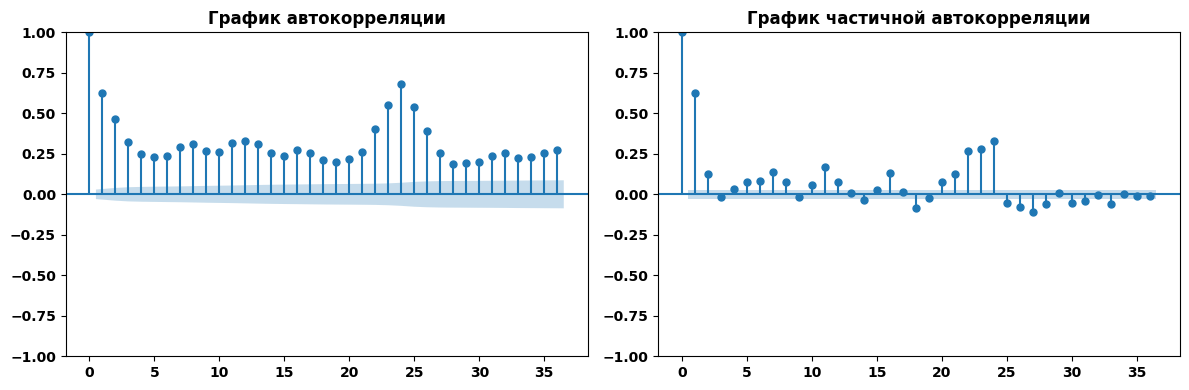

In [20]:
# построение графиков автокорреляции и частичной автокорреляции для значений временного ряда
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
plot_acf(taxi['num_orders'], lags = 10 * math.log10(len(taxi)), ax = axes[0])
axes[0].set_title('График автокорреляции')
plot_pacf(taxi['num_orders'], lags = 10 * math.log10(len(taxi)), ax = axes[1])
axes[1].set_title('График частичной автокорреляции')
plt.tight_layout()
plt.show()

**Вывод по промежуточному этапу**

По итогам анализа графиков автокорреляции и частичной автокорреляции можно явно сделать вывод о наличии ежедневной сезонной составляющей в данных временного ряда - **самые высокие значения корреляции находятся на отметке в 24 часа**

**Ситуация с количеством заказов такси повторяется каждые 24 часа**.

**Вывод**

1. Выведены на экран минимальное и максимальное значения даты и времени:
    * Стартовая граница временного ряда - 2018-03-01 00:00:00;
    * Конечная граница временного ряда - 2018-08-31 23:00:00.
2. Построены графики среднего количества заказов такси в различных временных разрезах (время суток, день недели, номер месяца):
    * По дням недели - наибольшее количество заказов приходится на **пятницу** и **понедельник**;
    * По времени суток - наблюдаются всплески заказов в следующие периоды:
        * Ночной период - **21 - 24 часа**;
        * Утренний период - **8 - 11 часов**;
        * Вечерний период - **15 - 17 часов**.
    * По номеру месяца - наибольшее количество заказов приходится на **август** месяц.
3. Построен график распределения значений заказов такси:
    * Аномально большие значения наблюдаются в каждый день недели - нет зависимости от дня недели;
    * Можно отметить суточную составляющую аномально больших значений - они наблюдаются в вечернее и ночное время.
4. Построен график временного ряда. По построенному графику заметен возрастающий линейный тренд на количество заказов такси - **среднее количество заказов растет на протяжении исследуемого периода данных**;
5. Проведена декомпозиция временного ряда на компоненты:
    * Наблюдается **линейный тренд** на увеличение количества заказов такси;
    * Наблюдается **ежедневная сезонность** - количество заказов такси увеличивается в вечернее время (в период 21 - 24 часов) и уменьшается в утреннее время (в период 5 - 7 часов);
    * Наблюдается **еженедельная сезонность** - количество заказов такси увеличивается в понедельник и пятницу и уменьшается в субботу и воскресенье
6. Проведен тест Дики-Фуллера стационарности временного ряда. Временной ряд является стационарным - **дополнительных преобразований по сглаживанию значений не требуется**;
7. Построены графики автокорреляции и частичной автокорреляции. **Ситуация с количеством заказов такси повторяется каждые 24 часа**.

## Построение моделей прогнозирования количества заказов такси <a class = 'anchor' id = 'Моделирование'></a>

### Подготовка данных для построения моделей <a class = 'anchor' id = 'Моделирование_подготовка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Формирование признака **скользящее среднее** для обучения моделей;
2. Формирование признака **отстающие значения** для обучения моделей;
3. Формирование **полиномиальных признаков** для обучения моделей;
4. Удаление пропусков из набора данных;
5. Разделение набора данных на обучающую и тестовую выборки;
6. Формирование вывода по итогам данного этапа.

In [21]:
# инициализация пользовательской функции создания новых признаков для обучения моделей
def make_features(data, max_lag, rolling_mean_size, max_degree):
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    for degree in range(2, max_degree + 1):
        data['degree_{}'.format(degree)] = data['num_orders'] ** degree

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
# применение функции генерации признаков к набору данных
make_features(taxi, 24, 24, 2) # размер окна и максимального лага установлен по итогам анализа графиков автокорреляции

# удаление пропусков из набора данных
taxi = taxi.dropna()

# просмотр структуры обновленного набора данных
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,degree_2,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,8100,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,14400,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,5625,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,4096,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,400,56.958333


In [23]:
# разделение набора на обучающую и тестовую выборки
train, test = train_test_split(taxi, shuffle = False, test_size = TEST_SIZE)

# проверка размеров выборок
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)
if train.index.max() < test.index.min():
    print('Временные индексы не пересекаются')
else:
    print('Временные индексы пересекаются')

Размер обучающей выборки: (3952, 31)
Размер тестовой выборки: (440, 31)
Временные индексы не пересекаются


In [24]:
# выделение целевого признака и признаков для обучения в обучающей и тестовой выборках
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

**Вывод**

1. Инициализирована пользовательская функция по созданию новых признаков на основе временного ряда;
2. Сформированы признаки **скользящее среднее**, **отстающие значения** и **полиномиальные признаки**
3. Выполнено удаление пропусков из набора данных
4. Выполнено разделение набора данных на обучающую и тестовую выборки;
5. Выполнена проверка размеров выборок и отсутствия пересечений по временным индексам.
6. Проведено выделение области признаков и целевой переменной.

### Блок прогнозирования заказов такси <a claslass = 'anchor' id = 'Моделирование_блок'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Подготовка моделей прогнозирования целевой переменной:
    * Прогнозирование константой;
    * Линейная регрессия;
    * SARIMA;
    * Holt-Winters;
    * RandomForestRegressor;
    * GradientBoostingRegressor.
2. Оценка качества моделей;
3. Выбор лучшей модели для прогнозирования целевой переменной;
4. Подготовка вывода по итогам текущего этапа.

In [ ]:
# инициализация пользовательской функции вывода итогов по моделям
def model_report(test, pred):
    print('Метрики модели')
    print('-----')
    print('Показатель MAE:', round(mean_absolute_error(test, pred), 1))
    print('Показатель RMSE:', round(root_mean_squared_error(test, pred), 1))
    print('Показатель MAPE: {:.1%}'.format(mean_absolute_percentage_error(test, pred)))
    print('-----')
    plt.figure(figsize = (10, 5))
    plt.plot(target_test.index, test, label = 'Тестовые значения')
    plt.plot(target_test.index, pred, label = 'Предсказанные значения')
    plt.title('Сравнение предсказанных и тестовых значений')
    plt.xlabel('Временной индекс')
    plt.xticks(rotation = 45)
    plt.ylabel('Количество заказов')
    plt.legend()
    plt.show()



#### Использование константного значения <a class = 'anchor' id = 'Моделирование_блок_константа'></a>

Метрики модели
-----
Показатель MAE: 70.8
Показатель RMSE: 87.2
Показатель MAPE: 49.1%
-----


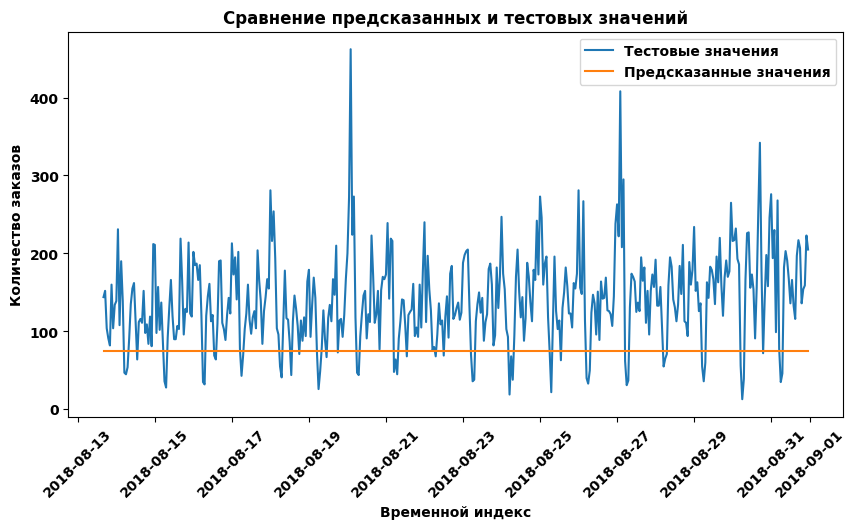

In [ ]:
# для прогнозирования целевой переменной будет использоваться медианное значение
pred_median = np.ones(target_test.shape) * target_train.median()

# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_median)

**Вывод по промежуточному этапу**

По итогам построения прогноза baseline-моделью с использованием константного значения получены следующие значения метрик:
* Показатель MAE: 70.8;
* Показатель RMSE: 87.2;
* Показатель MAPE: 49.1%

**Данные значения метрик являются базовыми** для дальнейшего сравнения с моделями машинного обучения.

### Линейная регрессия <a class = 'anchor' id = 'Моделирование_блок_lr'></a>

Метрики модели
-----
Показатель MAE: 17.0
Показатель RMSE: 35.3
Показатель MAPE: 11.2%
-----


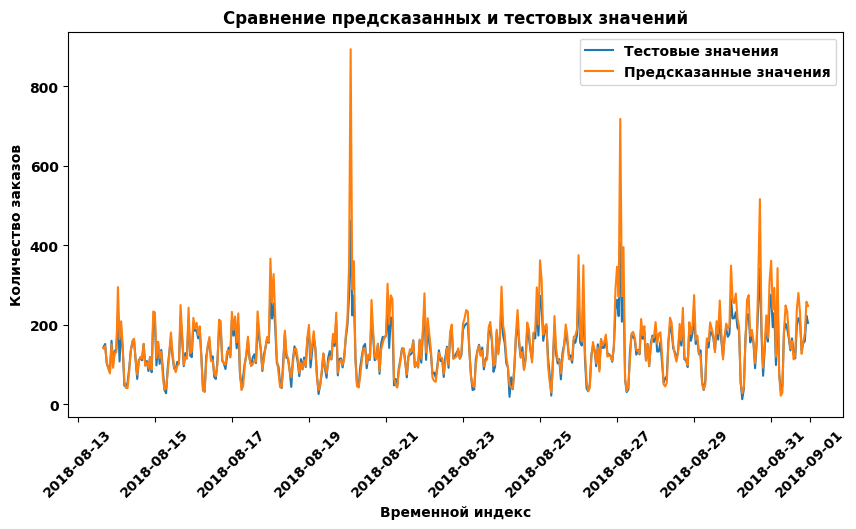

In [37]:
# инициализация объекта линейной регрессии
model_lr = LinearRegression()

# обучение модели линейной регрессии
model_lr.fit(features_train, target_train)
# построение прогноза
pred_lr = model_lr.predict(features_test)

# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_lr)

По итогам построения прогноза с  с использованием линейной регрессии получены следующие значения метрик:
* Показатель MAE: 17.0;
* Показатель RMSE: 35.3;
* Показатель MAPE: 11.2%

Модель показала себя лучше, чем предыдущая baseline-версия. Далее будет проведена проверка моделей анализа временных рядов.

### SARIMA <a class = 'anchor' id = 'Моделирование_блок_sarima'></a>

Метрики модели
-----
Показатель MAE: 111.7
Показатель RMSE: 129.7
Показатель MAPE: 107.7%
-----


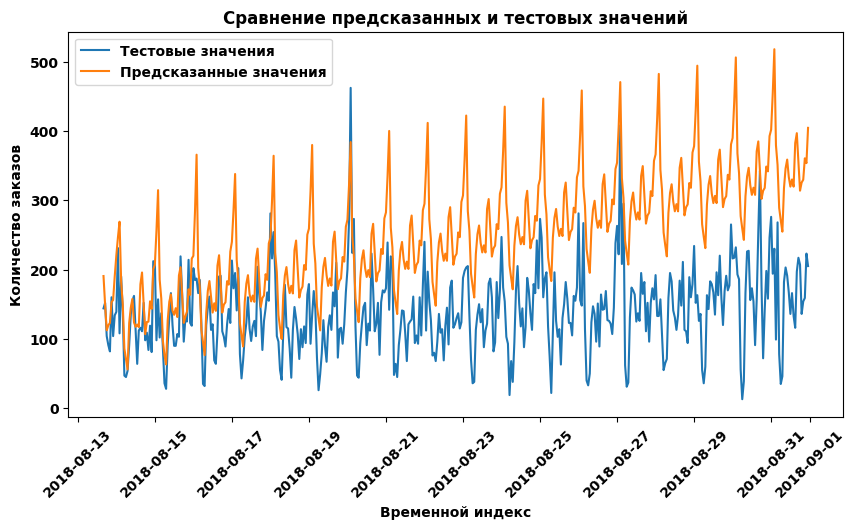

In [41]:
# построение модели сезонной ARIMA
model_sarima = SARIMAX(train['num_orders'], order = (5, 1, 0), seasonal_order = (2, 1, 0, 24))
model_sarima_fit = model_sarima.fit(disp = False)
pred_sarima = model_sarima_fit.predict(start = test.index[0], end = test.index[-1], dynamic = False)

# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_sarima)

По итогам построения прогноза с использованием SARIMA получены следующие значения метрик:
* Показатель MAE: 111.7;
* Показатель RMSE: 129.7;
* Показатель MAPE: 107.7%

Модель показала себя хуже, чем предыдущая - линейная регрессия. Модель верно учла сезонность, но при этом неверно учла тренд на возрастание значений.

### Holt-Winters <a class = 'anchor' id = 'Моделирование_блок_hw'></a>

Метрики модели
-----
Показатель MAE: 30.6
Показатель RMSE: 40.8
Показатель MAPE: 29.3%
-----


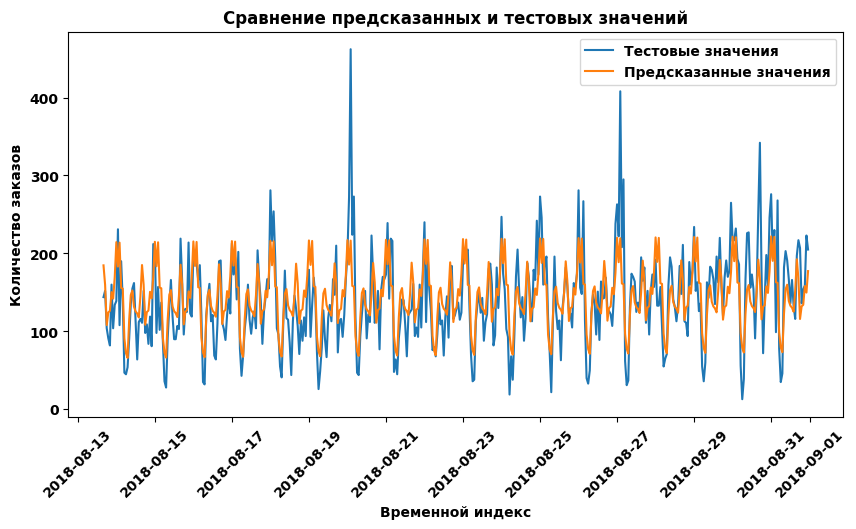

In [44]:
# построение модели экспоненциального сглаживания Хольта-Винтерса
model_holt = ExponentialSmoothing(
    train['num_orders'],
    seasonal_periods = 24,
    trend = 'add',
    seasonal = 'add')

model_holt_fit = model_holt.fit()
pred_holt = model_holt_fit.forecast(len(test))

# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_holt)

По итогам построения прогноза с использованием модели экспоненциального сглаживания получены следующие значения метрик:
* Показатель MAE: 30.6;
* Показатель RMSE: 40.8;
* Показатель MAPE: 29.3%

Модель показала себя лучше, чем предыдущая - SARIMA, но хуже, чем линейная регрессия. Модель верно учла тренд и динамику значений, но при этом неверно отреагировала на пиковые значения в данных. 

### RandomForestRegressor <a class = 'anchor' id = 'Моделирование_блок_rfr'></a>

Лучшие параметры: {'max_depth': 15, 'n_estimators': 50}
Лучшее значение RMSE: 3.5935627391355682
Метрики модели
-----
Показатель MAE: 3.3
Показатель RMSE: 12.5
Показатель MAPE: 1.4%
-----


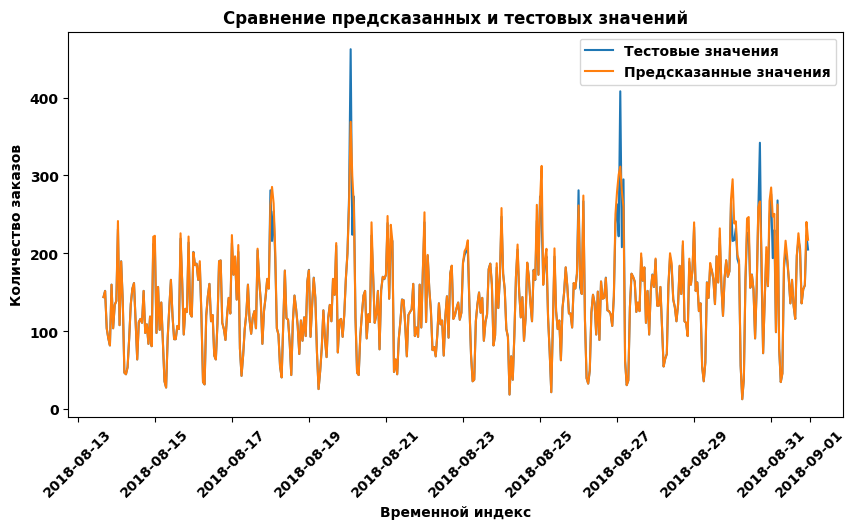

In [ ]:
# построение модели прогнозирования с использованием случайного леса и перебором параметров

grid_cv = GridSearchCV(
    estimator = RandomForestRegressor(random_state = RANDOM_STATE),
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15]
    },
    cv = 3,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)

grid_cv.fit(features_train, target_train)

print('Лучшие параметры:', grid_cv.best_params_)
print('Лучшее значение RMSE:', np.sqrt(-grid_cv.best_score_))

# инициализация модели случайного леса с лучшими параметрами
model_rfr = RandomForestRegressor(**grid_cv.best_params_, random_state = RANDOM_STATE)

# обучение модели случайного леса
model_rfr.fit(features_train, target_train)
# построение прогноза
pred_rfr = model_rfr.predict(features_test)


# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_rfr)

По итогам построения прогноза с использованием модели RandomForestRegressor получены следующие значения метрик:
* Показатель MAE: 3.3;
* Показатель RMSE: 12.5;
* Показатель MAPE: 1.4%

Модель показала себя лучше остальных моделей и верно учла тренд и сезонность изменений.

### GradientBoostingRegressor <a class = 'anchor' id = 'Моделирование_блок_gbr'></a>

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Лучшее значение RMSE: 3.1921646277324838
Метрики модели
-----
Показатель MAE: 1.4
Показатель RMSE: 4.7
Показатель MAPE: 0.8%
-----


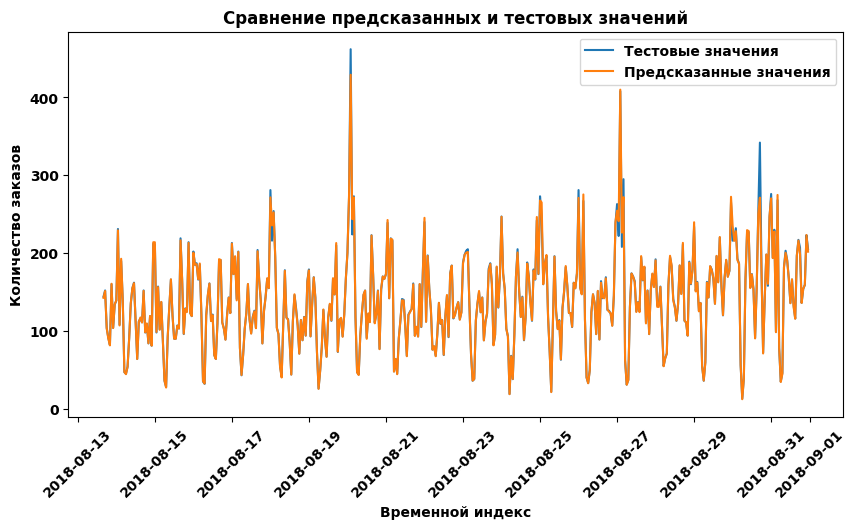

In [48]:
# построение модели градиентного бустинга с перебором параметров
grid_cv = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_grid={
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_cv.fit(features_train, target_train)

print('Лучшие параметры:', grid_cv.best_params_)
print('Лучшее значение RMSE:', np.sqrt(-grid_cv.best_score_))

# инициализация модели градиентного бустинга с лучшими параметрами
model_gbr = GradientBoostingRegressor(**grid_cv.best_params_, random_state=RANDOM_STATE)

# обучение модели градиентного бустинга
model_gbr.fit(features_train, target_train)

# построение прогноза
pred_gbr = model_gbr.predict(features_test)


# вывод на экран значений метрик и построение графика сравнения значений прогноза и тестовой выборки
model_report(target_test, pred_gbr) 

По итогам построения прогноза с использованием модели GradientBoostingRegressor получены следующие значения метрик:
* Показатель MAE: 1.4;
* Показатель RMSE: 4.7;
* Показатель MAPE: 0.8%

По итогу всех итераций обнаружена лучшая модель, которая верно учла тренд и сезонность значений, а также финальные метрики удовлетворяют поставленным перед проектом условиям.

**Вывод**
1. Построены и обучены модели:
    * Прогнозирование константой;
    * Линейная регрессия;
    * SARIMA;
    * Holt-Winters;
    * RandomForestRegressor;
    * GradientBoostingRegressor.
2. Получены следующие метрики:

|Метрики / Модель|Константа|Линейная регрессия|SARIMA|Holt-Winters|RandomForestRegressor|GradientBoostingRegressor|
|----------------|---------|------------------|------|------------|---------------------|-------------------------|
|MAE|70.8|17.0|111.7|30.6|3.3|1.4|
|RMSE|87.2|35.3|129.7|40.8|12.5|4.7|
|MAPE|49.1%|11.2%|107.7%|29.3%|1.4%|0.8%|

3. По условию **метрика RMSE не должна быть больше 48** лучшими моделями являются:
    * Линейная регрессия;
    * Модель Хольта-Уинтерса;
    * RandomForestRegressor;
    * GradientBoostingRegressor.
4. По совокупности метрик лучшей моделью является - GradientBoostingRegressor.

## Общий вывод <a class = 'anchor' id = 'Вывод'></a>

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn.
    * для решения задач машинного обучения:
        * LinearRegression - модель логистической регрессии;
        * RandomForestRegressor - модель случайного леса;
        * GradientBoostingRegressor - модель градиентного бустинга;
        * SARIMAX - модель SARIMAX для прогнозирования временных рядов;
        * ExponentialSmoothing - модель экспоненциального сглаживания;
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * GridSearchCV - механизм поиска гиперпараметров с перебором по "сетке";
        * cross_val_score - механизм кросс-валидации;
        * shuffle - механизм перемешивания данных.
    * для исследования временных рядов:
        * plot_acf - функция для построения графика автокорреляции;
        * plot_pacf - функция для построения графика частичной автокорреляции;
        * seasonal_decompose - функция для декомпозиции временного ряда на компоненты;
        * adfuller - функция для теста стационарности временного ряда.
    * для отключения предупреждений.
2. Инициализированы переменные:
    * **TEST_SIZE** для фиксирования размера тестовой выборки при разбиении наборов данных;
    * **RANDOM_STATE** для фиксирования случайности.
3. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **taxi**;
4. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения**;
    * Тип значений по признаку **datetime** не соответствует семантике столбца - необходимо выполнить конвертацию значений;
    * Наблюдаются аномально большие значения по признаку **num_orders** - необходимо провести анализ и выявить причину возникновения таких значений.
5. Проведена конвертация значений признака **datetime** к типу данных DateTime;
6. Выполнена установка индексам значений столбца **datetime**;
7. Выполнена сортировка значений по возрастанию с заменой предыдущего набора;
8. Выполнено ресемплирование значений по одному часу;
9. Выведены на экран минимальное и максимальное значения даты и времени:
    * Стартовая граница временного ряда - 2018-03-01 00:00:00;
    * Конечная граница временного ряда - 2018-08-31 23:00:00.
10. Построены графики среднего количества заказов такси в различных временных разрезах (время суток, день недели, номер месяца):
    * По дням недели - наибольшее количество заказов приходится на **пятницу** и **понедельник**;
    * По времени суток - наблюдаются всплески заказов в следующие периоды:
        * Ночной период - **21 - 24 часа**;
        * Утренний период - **8 - 11 часов**;
        * Вечерний период - **15 - 17 часов**.
    * По номеру месяца - наибольшее количество заказов приходится на **август** месяц.
11. Построен график распределения значений заказов такси:
    * Аномально большие значения наблюдаются в каждый день недели - нет зависимости от дня недели;
    * Можно отметить суточную составляющую аномально больших значений - они наблюдаются в вечернее и ночное время.
12. Построен график временного ряда. По построенному графику заметен возрастающий линейный тренд на количество заказов такси - **среднее количество заказов растет на протяжении исследуемого периода данных**;
13. Проведена декомпозиция временного ряда на компоненты:
    * Наблюдается **линейный тренд** на увеличение количества заказов такси;
    * Наблюдается **ежедневная сезонность** - количество заказов такси увеличивается в вечернее время (в период 21 - 24 часов) и уменьшается в утреннее время (в период 5 - 7 часов);
    * Наблюдается **еженедельная сезонность** - количество заказов такси увеличивается в понедельник и пятницу и уменьшается в субботу и воскресенье
14. Проведен тест Дики-Фуллера стационарности временного ряда. Временной ряд является стационарным - **дополнительных преобразований по сглаживанию значений не требуется**;
15. Построены графики автокорреляции и частичной автокорреляции. **Ситуация с количеством заказов такси повторяется каждые 24 часа**;
16. Инициализирована пользовательская функция по созданию новых признаков на основе временного ряда;
17. Сформированы признаки **скользящее среднее**, **отстающие значения** и **полиномиальные признаки**
18. Выполнено удаление пропусков из набора данных
19. Выполнено разделение набора данных на обучающую и тестовую выборки;
20. Выполнена проверка размеров выборок и отсутствия пересечений по временным индексам.
21. Проведено выделение области признаков и целевой переменной;
22. Построены и обучены модели:
    * Прогнозирование константой;
    * Линейная регрессия;
    * SARIMA;
    * Holt-Winters;
    * RandomForestRegressor;
    * GradientBoostingRegressor.
23. Получены следующие метрики:

|Метрики / Модель|Константа|Линейная регрессия|SARIMA|Holt-Winters|RandomForestRegressor|GradientBoostingRegressor|
|----------------|---------|------------------|------|------------|---------------------|-------------------------|
|MAE|70.8|17.0|111.7|30.6|3.3|1.4|
|RMSE|87.2|35.3|129.7|40.8|12.5|4.7|
|MAPE|49.1%|11.2%|107.7%|29.3%|1.4%|0.8%|

24. По условию **метрика RMSE не должна быть больше 48** лучшими моделями являются:
    * Линейная регрессия;
    * Модель Хольта-Уинтерса;
    * RandomForestRegressor;
    * GradientBoostingRegressor.
25. По совокупности метрик лучшей моделью является - GradientBoostingRegressor.